In [3]:
# %load first_cell.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns

%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv('/data/taxi_fare/train.csv', nrows = 25_000_000).drop(columns = 'key')

# Remove na
data = data.dropna()

# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()


In [144]:
# Filter outliers
data = data[data['abs_lat_diff'] < 1]
data = data[data['abs_lon_diff'] < 1]

In [138]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,...,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed,haversine
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,114.562929,0.002701,2009,6,...,False,False,False,17,26,21,0.726632,0.103805,3.454076e+09,1.031896
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,114.690571,0.036780,2010,1,...,False,False,False,16,52,16,0.702963,0.243280,3.471699e+09,8.459418
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,114.752512,0.008504,2011,8,...,False,False,False,0,35,0,0.024306,0.432044,3.522616e+09,1.391052
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,114.724710,0.004437,2012,4,...,False,False,False,4,30,42,0.187986,0.741141,3.543971e+09,2.802346
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,114.724663,0.011440,2010,3,...,False,False,False,7,51,0,0.327083,0.189583,3.477110e+09,2.001353


In [145]:
test = pd.read_csv('/data/taxi_fare/test.csv')

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

test_id = list(test.pop('key'))

In [146]:
test['abs_lat_diff'].describe()

count    9914.000000
mean        0.022133
std         0.025589
min         0.000000
25%         0.007279
50%         0.014715
75%         0.028261
max         0.633213
Name: abs_lat_diff, dtype: float64

In [147]:
test['abs_lon_diff'].describe()

count    9914.000000
mean        0.023348
std         0.036719
min         0.000000
25%         0.006354
50%         0.013123
75%         0.024557
max         0.849168
Name: abs_lon_diff, dtype: float64

In [148]:
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R * c
    return km

In [149]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

In [150]:
test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

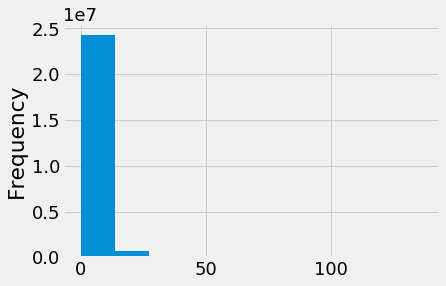

In [151]:
data['haversine'].plot.hist()

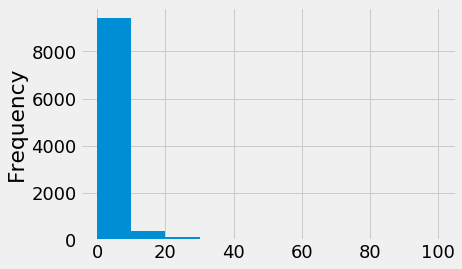

In [152]:
test['haversine'].plot.hist()

In [91]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, start_ref = pd.datetime(1900, 1, 1)):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[fldname]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    
    targ_pre = re.sub('[Dd]ate', '', fldname)
    targ_pre = re.sub('[Tt]ime', '', targ_pre)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    # If time is specified, add extra columns
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if time:
        # Add fractional time of day
        df[targ_pre + 'FractimeDay'] = (df[targ_pre + 'Hour'] / 24) + (df[targ_pre + 'Minute'] / 60 / 24) + (df[targ_pre + 'Second'] / 60 / 60 / 24)
        
        # Add fractional time of week
        df[targ_pre + 'FractimeWeek'] = ((df[targ_pre + 'Dayofweek'] * 24) + (df[targ_pre + 'FractimeDay'] * 24)) / (7 * 24)
    
    # Add seconds since start of reference
    df[targ_pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(fldname, axis=1)
        
    return df

In [ ]:
data = extract_dateinfo(data, 'pickup_datetime', time = True)
data.head()

In [129]:
test.head()

,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Is_month_end,...,pickup_Is_quarter_end,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
0,1,114.745235,0.008110,2015,1,5,27,1,27,False,...,False,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09
1,1,114.718269,0.012024,2015,1,5,27,1,27,False,...,False,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09
2,1,114.730914,0.002870,2011,10,40,8,5,281,False,...,False,False,False,False,11,53,44,0.495648,0.785093,3.527064e+09
3,1,114.758255,0.009288,2012,12,48,1,5,336,False,...,False,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09
4,1,114.778340,0.022519,2012,12,48,1,5,336,False,...,False,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09


In [153]:
test_ = extract_dateinfo(test, 'pickup_datetime', time = True)
test_.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,haversine,pickup_Year,pickup_Month,...,pickup_Is_quarter_end,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
0,-73.973320,40.763805,-73.981430,40.743835,1,0.019970,0.008110,2.325812,2015,1,...,False,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09
1,-73.986862,40.719383,-73.998886,40.739201,1,0.019817,0.012024,2.428018,2015,1,...,False,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09
2,-73.982524,40.751260,-73.979654,40.746139,1,0.005121,0.002870,0.619308,2011,10,...,False,False,False,False,11,53,44,0.495648,0.785093,3.527064e+09
3,-73.981160,40.767807,-73.990448,40.751635,1,0.016172,0.009288,1.963187,2012,12,...,False,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09
4,-73.966046,40.789775,-73.988565,40.744427,1,0.045348,0.022519,5.393220,2012,12,...,False,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09


In [154]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [155]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,...,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed,haversine
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.009041,0.002701,2009,6,...,False,False,False,17,26,21,0.726632,0.103805,3.454076e+09,1.031896
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.070701,0.036780,2010,1,...,False,False,False,16,52,16,0.702963,0.243280,3.471699e+09,8.459418
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.010708,0.008504,2011,8,...,False,False,False,0,35,0,0.024306,0.432044,3.522616e+09,1.391052
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.024949,0.004437,2012,4,...,False,False,False,4,30,42,0.187986,0.741141,3.543971e+09,2.802346
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.015754,0.011440,2010,3,...,False,False,False,7,51,0,0.327083,0.189583,3.477110e+09,2.001353


In [156]:
train = data.iloc[:, 5:]

labels = np.array(data['fare_amount']).reshape((-1, ))
lr.fit(train, labels)

In [109]:
lr.score(train, labels)

0.006428064820525603

In [170]:
train.head()

,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Is_month_end,...,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed,haversine
0,1,0.009041,0.002701,2009,6,25,15,0,166,False,...,False,False,False,17,26,21,0.726632,0.103805,3.454076e+09,1.031896
1,1,0.070701,0.036780,2010,1,1,5,1,5,False,...,False,False,False,16,52,16,0.702963,0.243280,3.471699e+09,8.459418
2,2,0.010708,0.008504,2011,8,33,18,3,230,False,...,False,False,False,0,35,0,0.024306,0.432044,3.522616e+09,1.391052
3,1,0.024949,0.004437,2012,4,16,21,5,112,False,...,False,False,False,4,30,42,0.187986,0.741141,3.543971e+09,2.802346
4,1,0.015754,0.011440,2010,3,10,9,1,68,False,...,False,False,False,7,51,0,0.327083,0.189583,3.477110e+09,2.001353


In [171]:
test = test_.iloc[:, 4:]
test = test[train.columns]
test.head()

,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,pickup_Week,pickup_Day,pickup_Dayofweek,pickup_Dayofyear,pickup_Is_month_end,...,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed,haversine
0,1,0.019970,0.008110,2015,1,5,27,1,27,False,...,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09,2.325812
1,1,0.019817,0.012024,2015,1,5,27,1,27,False,...,False,False,False,13,8,24,0.547500,0.221071,3.631353e+09,2.428018
2,1,0.005121,0.002870,2011,10,40,8,5,281,False,...,False,False,False,11,53,44,0.495648,0.785093,3.527064e+09,0.619308
3,1,0.016172,0.009288,2012,12,48,1,5,336,False,...,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09,1.963187
4,1,0.045348,0.022519,2012,12,48,1,5,336,False,...,False,False,False,21,12,12,0.883472,0.840496,3.563385e+09,5.393220


In [160]:
[x for x in train if x not in test]

[]

In [120]:
corrs = data.sample(1_000_000).corr()

In [121]:
corrs.sort_values('fare_amount').tail()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,...,pickup_Is_quarter_end,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
pickup_Month,0.022025,-0.000721,0.001780,-0.000836,0.000110,0.006649,-0.000741,-0.000269,-0.117903,1.000000,...,0.030018,-0.021091,0.082804,-0.071911,-0.006915,-0.001638,-0.045685,-0.007018,-0.009665,0.036138
pickup_Dayofyear,0.022035,-0.000359,0.001395,-0.000492,-0.000300,0.007126,-0.000933,-0.000212,-0.118458,0.996547,...,0.044559,-0.035014,0.089945,-0.078005,-0.006854,-0.001604,-0.046251,-0.006956,-0.009015,0.036115
pickup_Year,0.109931,0.005726,-0.006842,0.006224,-0.005614,0.003825,-0.004375,0.008264,1.000000,-0.117903,...,-0.004309,0.006268,-0.007476,0.010520,-0.000410,-0.001857,0.086327,-0.000420,0.007569,0.988033
pickup_Elapsed,0.114066,0.005702,-0.006666,0.006182,-0.005693,0.004965,-0.004541,0.008282,0.988033,0.036138,...,0.002583,0.000869,0.006449,-0.001533,-0.001073,-0.002099,0.079685,-0.001099,0.006239,1.000000
fare_amount,1.000000,0.007253,-0.006516,0.007581,-0.005549,0.012747,-0.007971,0.007486,0.109931,0.022025,...,-0.001732,0.000551,-0.002887,0.000225,-0.016859,-0.007407,-0.001609,-0.017170,-0.002303,0.114066


In [122]:
corrs.sort_values('fare_amount').head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,pickup_Year,pickup_Month,...,pickup_Is_quarter_end,pickup_Is_quarter_start,pickup_Is_year_end,pickup_Is_year_start,pickup_Hour,pickup_Minute,pickup_Second,pickup_FractimeDay,pickup_FractimeWeek,pickup_Elapsed
pickup_FractimeDay,-0.017170,-0.001506,0.001000,-0.002195,0.001003,0.013442,0.002951,0.000393,-0.000420,-0.007018,...,0.000107,-0.006114,0.002681,-0.017936,0.999019,0.046618,-0.008954,1.000000,0.053423,-0.001099
pickup_Hour,-0.016859,-0.001583,0.001037,-0.002227,0.001082,0.013679,0.003007,0.000398,-0.000410,-0.006915,...,0.000210,-0.006104,0.002732,-0.017934,1.000000,0.002340,-0.009811,0.999019,0.053253,-0.001073
abs_lat_diff,-0.007971,-0.563556,0.427503,-0.682586,0.302198,0.000570,1.000000,0.257052,-0.004375,-0.000741,...,0.000322,-0.000064,0.000984,0.000658,0.003007,-0.001321,0.006512,0.002951,0.000839,-0.004541
pickup_Minute,-0.007407,0.001872,-0.001012,0.000874,-0.001951,-0.001040,-0.001321,-0.000063,-0.001857,-0.001638,...,-0.002307,-0.000532,-0.001048,-0.000657,0.002340,1.000000,0.000420,0.046618,0.005138,-0.002099
pickup_latitude,-0.006516,-0.573998,1.000000,-0.506029,0.713774,-0.000373,0.427503,-0.010784,-0.006842,0.001780,...,0.001204,0.000739,0.001255,0.001000,0.001037,-0.001012,0.010065,0.001000,-0.001088,-0.006666


In [123]:
data.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'abs_lat_diff', 'abs_lon_diff', 'pickup_Year', 'pickup_Month',
       'pickup_Week', 'pickup_Day', 'pickup_Dayofweek', 'pickup_Dayofyear',
       'pickup_Is_month_end', 'pickup_Is_month_start', 'pickup_Is_quarter_end',
       'pickup_Is_quarter_start', 'pickup_Is_year_end', 'pickup_Is_year_start',
       'pickup_Hour', 'pickup_Minute', 'pickup_Second', 'pickup_FractimeDay',
       'pickup_FractimeWeek', 'pickup_Elapsed'],
      dtype='object')

In [136]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

subset = data[['abs_lat_diff', 'abs_lon_diff', 'haversine']]

X_train, X_valid, y_train, y_valid = train_test_split(subset, labels, test_size = 0.4)

test_subset = test[['abs_lat_diff', 'abs_lon_diff']]

valid_preds = lr.fit(X_train, y_train).predict(X_valid)
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_valid, valid_preds))}')

Root mean squared error: 9.805678650006033


In [137]:
test['abs_lat_diff'].describe()

count    9914.000000
mean      114.724697
std         0.043956
min       114.346490
25%       114.713037
50%       114.731447
75%       114.747440
max       115.352699
Name: abs_lat_diff, dtype: float64

In [134]:
lr.intercept_

11.322870970671138

In [135]:
lr.coef_

array([0.00071612])

In [172]:
preds = lr.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr.csv', index = False)

(array([9.129e+03, 5.710e+02, 2.070e+02, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([  3.07638453,  21.76810507,  40.4598256 ,  59.15154613,
         77.84326666,  96.53498719, 115.22670773, 133.91842826,
        152.61014879, 171.30186932, 189.99358985]),
 <a list of 10 Patch objects>)

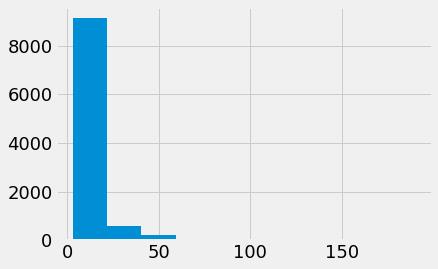

In [173]:
plt.hist(preds)

In [166]:
!cd "~/git/neural-networks/taxi_fare/" && kaggle competitions submit -f sub_lr.csv -m "Corrected Linear Regression" new-york-city-taxi-fare-prediction

/bin/sh: 1: cd: can't cd to ~/git/neural-networks/taxi_fare/


In [174]:
!kaggle competitions submissions new-york-city-taxi-fare-prediction

fileName       date                 description                  status    publicScore        privateScore  
-------------  -------------------  ---------------------------  --------  -----------------  ------------  
sub_lr.csv     2018-09-05 01:12:12  Corrected Linear Regression  complete  5.14856            None          
sub_lr.csv     2018-09-05 01:09:54  Corrected Linear Regression  complete  15034142279.28590  None          
sub_lr.csv     2018-09-05 00:45:19  Linear Regression            complete  9.32197            None          
sub_embed.csv  2018-09-04 23:50:32  None                         complete  7.77266            None          
sub_cyc.csv    2018-09-02 19:54:54  None                         complete  9.92623            None          
sub.csv        2018-09-02 01:33:32  None                         complete  15.07163           None          


In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 1000, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
random_forest.fit(train, labels)

In [ ]:
preds = random_forest.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_random_forest.csv', index = False)

In [6]:

fldname = 'pickup_datetime'
targ_pre = re.sub('[Dd]ate$', '', fldname)

In [7]:
targ_pre

'pickup_datetime'